# CS 109A/AC 209A/STAT 121A Data Science: Final Project
**Harvard University**<br>
**Fall 2016**<br>
**Instructors:** W. Pan, P. Protopapas, K. Rader<br>
**Members: ** Shawn Pan, Xinyuan (Amy) Wang, Ming-long Wu

## Remark - 041_preprocessing ##

- Add calendar and review data to listing
- Do log(price)
- Do KNN clustering of location to replace zip code, longitude and latitude
- Add prior to the review scores


### Load listing data ###

In [1]:
import time
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import savgol_filter
from scipy.stats import mode
import goslate
from langdetect import detect
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib import colors
import matplotlib.dates as mdates
from datetime import datetime
from collections import Counter
from mpl_toolkits.basemap import Basemap
import statsmodels.api as sm
from sklearn import preprocessing
from collections import Counter
%matplotlib inline

In [2]:
# Load listing data
listing = pd.read_csv('../../Data/listings_clean.csv')
print(listing.columns.values)
listing.head()

['id' 'host_since' 'zipcode' 'latitude' 'longitude' 'property_type'
 'room_type' 'accommodates' 'bathrooms' 'bedrooms' 'beds' 'bed_type'
 'guests_included' 'minimum_nights' 'maximum_nights' 'availability_30'
 'availability_60' 'availability_90' 'availability_365' 'number_of_reviews'
 'first_review' 'last_review' 'review_scores_rating'
 'review_scores_accuracy' 'review_scores_cleanliness'
 'review_scores_checkin' 'review_scores_communication'
 'review_scores_location' 'review_scores_value' 'host_listing_count'
 'price']


,id,host_since,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,price
0,1069266,1926,10022.0,40.756852,-73.964754,0,0,2,1.0,1.0,...,2542.0,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,160
1,1846722,1625,NaN,40.830599,-73.941014,0,0,10,1.0,3.0,...,2554.0,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2,105
2,2061725,1831,11221.0,40.692189,-73.924120,0,1,2,1.0,1.0,...,2554.0,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,58
3,44974,953,10011.0,40.734751,-74.002592,0,0,2,1.0,1.0,...,2494.0,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,185
4,4701675,2479,10011.0,40.745282,-73.997836,0,0,2,1.0,1.0,...,2533.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,195


In [3]:
print('listing size: ' + str(listing.shape))

listing size: (27392, 31)


### Remove 5% samples from smallest zipcode clusters ###

In [4]:
# remove small zipcode clusters, with 95% data left
# count each zipcode entries
nb_counts = Counter(listing['zipcode'])
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
# select clusters with size >= 50
tdf1 = tdf[tdf.values>=50]
print 'Remaining data proportion: ' + str(float(sum(tdf1.values))/listing.shape[0])
# get zipcode clusters
zipcode_included = tdf1.index

listing = listing.loc[listing['zipcode'].isin(zipcode_included)]
print listing.shape

Remaining data proportion: 0.94976635514
(26016, 31)


In [5]:
# Cleaning out some entries
listing = listing[listing.bedrooms != 0]
print('listing size after cleaning: ' + str(listing.shape))
listing = listing[listing.beds != 0]
print('listing size after cleaning: ' + str(listing.shape))
listing = listing[listing.price != 0]
print('listing size after cleaning: ' + str(listing.shape))
# listing = listing.dropna(axis=0)
# print('listing size after cleaning: ' + str(listing.shape))

listing size after cleaning: (23755, 31)
listing size after cleaning: (23755, 31)
listing size after cleaning: (23755, 31)


In [6]:
listing.head(n=5)

,id,host_since,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,price
0,1069266,1926,10022.0,40.756852,-73.964754,0,0,2,1.0,1.0,...,2542.0,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,160
2,2061725,1831,11221.0,40.692189,-73.924120,0,1,2,1.0,1.0,...,2554.0,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,58
3,44974,953,10011.0,40.734751,-74.002592,0,0,2,1.0,1.0,...,2494.0,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,185
4,4701675,2479,10011.0,40.745282,-73.997836,0,0,2,1.0,1.0,...,2533.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,195
5,68914,1106,11231.0,40.679060,-73.994730,0,0,6,1.0,2.0,...,2536.0,96.0,10.0,9.0,10.0,9.0,10.0,9.0,2,165


### Check distribution of Y

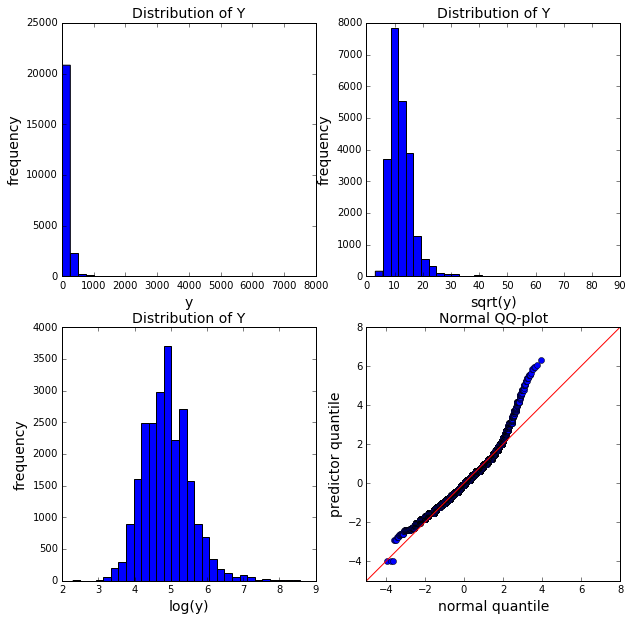

In [7]:
y = listing['price']

# Check normality of y
fig1, ax1 = plt.subplots(2, 2, figsize=(10, 10))
# Plot Y distribution
ax1[0, 0].hist(y, bins = 32, facecolor = 'blue')
ax1[0, 0].set_xlabel('y', fontsize=14)
ax1[0, 0].set_ylabel('frequency', fontsize=14)
ax1[0, 0].set_title('Distribution of Y', fontsize=14)

# Plot Y distribution
ax1[0, 1].hist(np.sqrt(y), bins = 32, facecolor = 'blue')
ax1[0, 1].set_xlabel('sqrt(y)', fontsize=14)
ax1[0, 1].set_ylabel('frequency', fontsize=14)
ax1[0, 1].set_title('Distribution of Y', fontsize=14)

# Plot Y distribution
ax1[1, 0].hist(np.log(y), bins = 32, facecolor = 'blue')
ax1[1, 0].set_xlabel('log(y)', fontsize=14)
ax1[1, 0].set_ylabel('frequency', fontsize=14)
ax1[1, 0].set_title('Distribution of Y', fontsize=14)

# QQ-plot of y
sm.qqplot(np.log(y),ax=ax1[1, 1], fit=True, line='45')
ax1[1, 1].set_xlabel('normal quantile', fontsize=14)
ax1[1, 1].set_ylabel('predictor quantile', fontsize=14)
ax1[1, 1].set_title('Normal QQ-plot', fontsize=14)


## Transformation of y ##
- From above test, we choose to apply log transformation to y.
- Log(y) is symmetric and is closer to normal.


In [8]:
#Feature Extraction:
#Use the features we decided last time
features = ['zipcode', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 
            'bathrooms', 'bedrooms', 'beds', 'bed_type', 'number_of_reviews', 'review_scores_rating',
            'review_scores_accuracy', 'review_scores_cleanliness', 
            'review_scores_checkin', 'review_scores_communication', 
            'review_scores_location', 'review_scores_value', 'host_listing_count']

df_x = listing[features]
df_x.head()

,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count
0,10022.0,40.756852,-73.964754,0,0,2,1.0,1.0,1.0,0,62,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1
2,11221.0,40.692189,-73.924120,0,1,2,1.0,1.0,2.0,0,35,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4
3,10011.0,40.734751,-74.002592,0,0,2,1.0,1.0,1.0,0,26,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1
4,10011.0,40.745282,-73.997836,0,0,2,1.0,1.0,2.0,0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1
5,11231.0,40.679060,-73.994730,0,0,6,1.0,2.0,3.0,0,16,96.0,10.0,9.0,10.0,9.0,10.0,9.0,2


In [9]:
print('x size: ' + str(df_x.shape))

x size: (23755, 19)


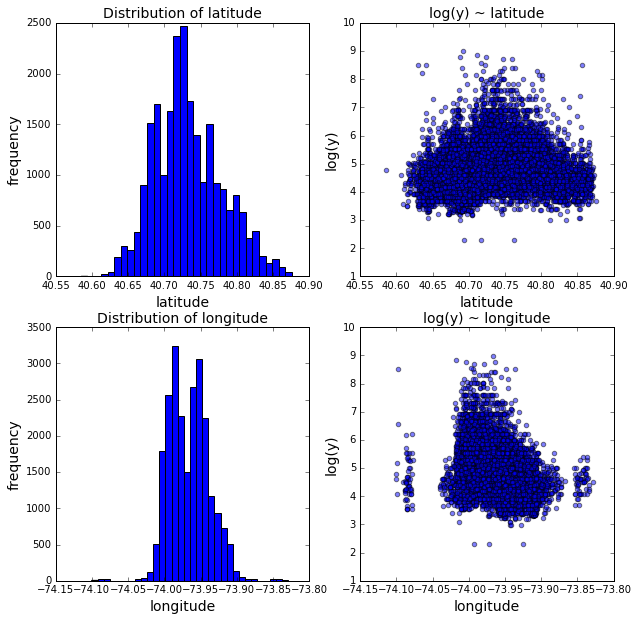

In [10]:
# Examine predictor distribution
fig2, ax2 = plt.subplots(2, 2, figsize=(10, 10))

predictor = df_x['latitude']
# Plot latitude distribution
ax2[0, 0].hist(predictor, bins = 32, facecolor = 'blue')
ax2[0, 0].set_xlabel('latitude', fontsize=14)
ax2[0, 0].set_ylabel('frequency', fontsize=14)
ax2[0, 0].set_title('Distribution of latitude', fontsize=14)

# Plot log(y) ~ latitude distribution
ax2[0, 1].scatter(predictor, np.log(y), c='blue', alpha=0.5)
ax2[0, 1].set_xlabel('latitude', fontsize=14)
ax2[0, 1].set_ylabel('log(y)', fontsize=14)
ax2[0, 1].set_title('log(y) ~ latitude', fontsize=14)


predictor = df_x['longitude']
# Plot latitude distribution
ax2[1, 0].hist(predictor, bins = 32, facecolor = 'blue')
ax2[1, 0].set_xlabel('longitude', fontsize=14)
ax2[1, 0].set_ylabel('frequency', fontsize=14)
ax2[1, 0].set_title('Distribution of longitude', fontsize=14)

# Plot log(y) ~ latitude distribution
ax2[1, 1].scatter(predictor, np.log(y), c='blue', alpha=0.5)
ax2[1, 1].set_xlabel('longitude', fontsize=14)
ax2[1, 1].set_ylabel('log(y)', fontsize=14)
ax2[1, 1].set_title('log(y) ~ longitude', fontsize=14)

## Deal with missing data
- Check missing data in each predictors
- 

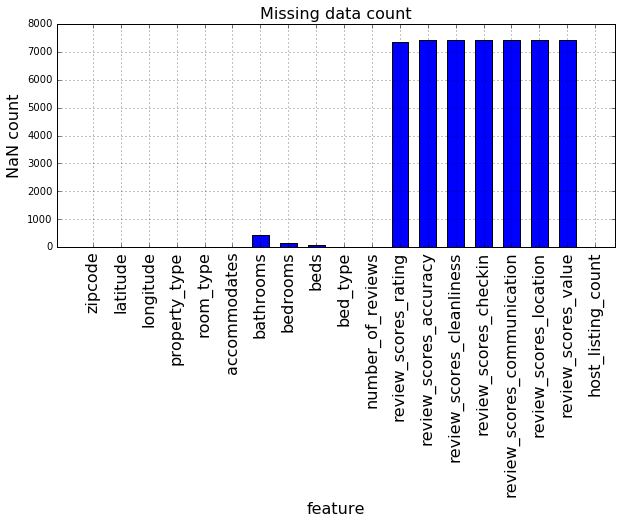

In [11]:
# Count NaN in each column
col_names = df_x.columns.values
nan_cnt = np.empty(df_x.shape[1])
for idx in range(df_x.shape[1]):
    nan_cnt[idx] = sum(np.isnan(df_x[col_names[idx]]))

# Bar chart
# Plot weekday average price in 2015
fig3, ax3 = plt.subplots(1, 1, figsize=(10, 4))

x = range(1,df_x.shape[1]+1)
width = 0.6
ax3.bar(x, nan_cnt, width)

ax3.set_xlim((0, df_x.shape[1]+1))
# ax3.set_ylim((175, 185))

# ax3.set_xticks([i+width/2 for i in x])
ax3.set_xticklabels(col_names)
plt.xticks([i+width/2 for i in x], rotation='vertical', fontsize=16)

ax3.set_xlabel('feature', fontsize=16)
ax3.set_ylabel('NaN count', fontsize=16)
ax3.set_title('Missing data count', fontsize=16)

plt.grid()
plt.show()

In [12]:
# Check NaN count in each predictor
print zip(col_names, nan_cnt)


[('zipcode', 0.0), ('latitude', 0.0), ('longitude', 0.0), ('property_type', 0.0), ('room_type', 0.0), ('accommodates', 0.0), ('bathrooms', 427.0), ('bedrooms', 139.0), ('beds', 84.0), ('bed_type', 0.0), ('number_of_reviews', 0.0), ('review_scores_rating', 7359.0), ('review_scores_accuracy', 7423.0), ('review_scores_cleanliness', 7424.0), ('review_scores_checkin', 7425.0), ('review_scores_communication', 7422.0), ('review_scores_location', 7424.0), ('review_scores_value', 7427.0), ('host_listing_count', 0.0)]


## Cleaning out missing review scores
- There are almost 8000 entries with missing review scores.
- For entries with any missing review score, all scores are missing.
- Therefore, any method to fill missing scores may not reflect the true review feedback.

In [13]:
listing1 = listing
print listing1.shape
listing1 = listing1[pd.notnull(listing1['review_scores_rating'])]
print listing1.shape
listing1 = listing1[pd.notnull(listing1['review_scores_accuracy'])]
print listing1.shape
listing1 = listing1[pd.notnull(listing1['review_scores_cleanliness'])]
print listing1.shape
listing1 = listing1[pd.notnull(listing1['review_scores_checkin'])]
print listing1.shape
listing1 = listing1[pd.notnull(listing1['review_scores_communication'])]
print listing1.shape
listing1 = listing1[pd.notnull(listing1['review_scores_location'])]
print listing1.shape
listing1 = listing1[pd.notnull(listing1['review_scores_value'])]
print listing1.shape


(23755, 31)
(16396, 31)
(16320, 31)
(16312, 31)
(16305, 31)
(16302, 31)
(16299, 31)
(16293, 31)


## Select features, log(price) and one-hot encoding

In [14]:
# Get features from dataframe and add log(price) as response variable
df_cleaned = listing1[features]
df_cleaned['log_price'] = pd.Series(np.log(listing1['price']),index=listing1.index)
df_cleaned.head()

/Applications/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,log_price
0,10022.0,40.756852,-73.964754,0,0,2,1.0,1.0,1.0,0,62,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,5.075174
2,11221.0,40.692189,-73.924120,0,1,2,1.0,1.0,2.0,0,35,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,4.060443
3,10011.0,40.734751,-74.002592,0,0,2,1.0,1.0,1.0,0,26,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,5.220356
4,10011.0,40.745282,-73.997836,0,0,2,1.0,1.0,2.0,0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,5.273000
5,11231.0,40.679060,-73.994730,0,0,6,1.0,2.0,3.0,0,16,96.0,10.0,9.0,10.0,9.0,10.0,9.0,2,5.105945


In [15]:
# Check again the rest of NaN
col_names = df_cleaned.columns.values
nan_cnt = np.empty(df_cleaned.shape[1])
for idx in range(df_cleaned.shape[1]):
    nan_cnt[idx] = sum(np.isnan(df_cleaned[col_names[idx]]))

# Check NaN count in each predictor
print zip(col_names, nan_cnt)

[('zipcode', 0.0), ('latitude', 0.0), ('longitude', 0.0), ('property_type', 0.0), ('room_type', 0.0), ('accommodates', 0.0), ('bathrooms', 333.0), ('bedrooms', 121.0), ('beds', 33.0), ('bed_type', 0.0), ('number_of_reviews', 0.0), ('review_scores_rating', 0.0), ('review_scores_accuracy', 0.0), ('review_scores_cleanliness', 0.0), ('review_scores_checkin', 0.0), ('review_scores_communication', 0.0), ('review_scores_location', 0.0), ('review_scores_value', 0.0), ('host_listing_count', 0.0), ('log_price', 0.0)]


### Fill rest of missing values with mean and mod

In [16]:
#categorical and numerical column names
cate = ['zipcode', 'property_type', 'room_type', 'bed_type']
nume = [c for c in df_x.columns.values if c not in cate]

#fill categorical with mode, numerical with rounded mean
df_cleaned[cate] = df_cleaned[cate].apply(lambda x:x.fillna(x.value_counts().index[0]))
df_cleaned[nume] = df_cleaned[nume].apply(lambda x:x.fillna(round(x.mean())))

df_cleaned.head()

/Applications/anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,log_price
0,10022.0,40.756852,-73.964754,0,0,2,1.0,1.0,1.0,0,62,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,5.075174
2,11221.0,40.692189,-73.924120,0,1,2,1.0,1.0,2.0,0,35,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,4.060443
3,10011.0,40.734751,-74.002592,0,0,2,1.0,1.0,1.0,0,26,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,5.220356
4,10011.0,40.745282,-73.997836,0,0,2,1.0,1.0,2.0,0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,5.273000
5,11231.0,40.679060,-73.994730,0,0,6,1.0,2.0,3.0,0,16,96.0,10.0,9.0,10.0,9.0,10.0,9.0,2,5.105945


In [17]:
# Create a new data frame to store one-hot encoding of attributes
df_expanded = pd.DataFrame({})

# Iterate over all attributes
for column in df_cleaned.columns:
    # Check if attribute is categorical
    if column in cate:
        # use one-hot encoding for this column
        encoding = pd.get_dummies(df_cleaned[column])
        # append expanded attribute to data frame
        df_expanded = pd.concat([df_expanded, encoding], axis = 1)
    else:
        df_expanded = pd.concat([df_expanded, df_cleaned[column]], axis = 1)

df_expanded.head()

,10001.0,10002.0,10003.0,10004.0,10005.0,10006.0,10009.0,10010.0,10011.0,10012.0,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,log_price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,5.075174
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,35,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,4.060443
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,26,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,5.220356
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,5.273000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16,96.0,10.0,9.0,10.0,9.0,10.0,9.0,2,5.105945


In [18]:
# Check column names
df_expanded.columns.values

array([10001.0, 10002.0, 10003.0, 10004.0, 10005.0, 10006.0, 10009.0,
       10010.0, 10011.0, 10012.0, 10013.0, 10014.0, 10016.0, 10017.0,
       10018.0, 10019.0, 10021.0, 10022.0, 10023.0, 10024.0, 10025.0,
       10026.0, 10027.0, 10028.0, 10029.0, 10030.0, 10031.0, 10032.0,
       10033.0, 10034.0, 10035.0, 10036.0, 10037.0, 10038.0, 10039.0,
       10040.0, 10065.0, 10075.0, 10128.0, 10280.0, 10301.0, 11101.0,
       11102.0, 11103.0, 11104.0, 11105.0, 11106.0, 11201.0, 11205.0,
       11206.0, 11207.0, 11209.0, 11210.0, 11211.0, 11213.0, 11215.0,
       11216.0, 11217.0, 11218.0, 11220.0, 11221.0, 11222.0, 11225.0,
       11226.0, 11230.0, 11231.0, 11233.0, 11237.0, 11238.0, 11249.0,
       11372.0, 11375.0, 11377.0, 11385.0, 'latitude', 'longitude', 0, 1,
       2, 3, 4, 5, 0, 1, 2, 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 0, 1, 2, 3, 4, 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_score

In [20]:
df_expanded.columns=[10001.0, 10002.0, 10003.0, 10004.0, 10005.0, 10006.0, 10009.0,
       10010.0, 10011.0, 10012.0, 10013.0, 10014.0, 10016.0, 10017.0,
       10018.0, 10019.0, 10021.0, 10022.0, 10023.0, 10024.0, 10025.0,
       10026.0, 10027.0, 10028.0, 10029.0, 10030.0, 10031.0, 10032.0,
       10033.0, 10034.0, 10035.0, 10036.0, 10037.0, 10038.0, 10039.0,
       10040.0, 10065.0, 10075.0, 10128.0, 10280.0, 10301.0, 11101.0,
       11102.0, 11103.0, 11104.0, 11105.0, 11106.0, 11201.0, 11205.0,
       11206.0, 11207.0, 11209.0, 11210.0, 11211.0, 11213.0, 11215.0,
       11216.0, 11217.0, 11218.0, 11220.0, 11221.0, 11222.0, 11225.0,
       11226.0, 11230.0, 11231.0, 11233.0, 11237.0, 11238.0, 11249.0,
       11372.0, 11375.0, 11377.0, 11385.0, 'latitude', 'longitude', 'prop 0', 'prop 1',
       'prop 2', 'prop 3', 'prop 4', 'prop 5', 'room 0', 'room 1', 'room 2', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed 0', 'bed 1', 'bed 2', 'bed 3', 'bed 4', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'host_listing_count', 'log_price']

df_expanded.columns.values

array([10001.0, 10002.0, 10003.0, 10004.0, 10005.0, 10006.0, 10009.0,
       10010.0, 10011.0, 10012.0, 10013.0, 10014.0, 10016.0, 10017.0,
       10018.0, 10019.0, 10021.0, 10022.0, 10023.0, 10024.0, 10025.0,
       10026.0, 10027.0, 10028.0, 10029.0, 10030.0, 10031.0, 10032.0,
       10033.0, 10034.0, 10035.0, 10036.0, 10037.0, 10038.0, 10039.0,
       10040.0, 10065.0, 10075.0, 10128.0, 10280.0, 10301.0, 11101.0,
       11102.0, 11103.0, 11104.0, 11105.0, 11106.0, 11201.0, 11205.0,
       11206.0, 11207.0, 11209.0, 11210.0, 11211.0, 11213.0, 11215.0,
       11216.0, 11217.0, 11218.0, 11220.0, 11221.0, 11222.0, 11225.0,
       11226.0, 11230.0, 11231.0, 11233.0, 11237.0, 11238.0, 11249.0,
       11372.0, 11375.0, 11377.0, 11385.0, 'latitude', 'longitude',
       'prop 0', 'prop 1', 'prop 2', 'prop 3', 'prop 4', 'prop 5',
       'room 0', 'room 1', 'room 2', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'bed 0', 'bed 1', 'bed 2', 'bed 3', 'bed 4',
       'number_of_reviews',

In [21]:
# Save data
df_expanded.to_csv('../../Data/data_preprocessed.csv', index=False)